In [23]:
import pandas as pd
from datetime import datetime
import bs4
import random
import requests
import json
# !pip install fake-useragent
from fake_useragent import UserAgent
import itertools as it

urls_social_network = {
    
    'WhatsApp': 'https://androidapksfree.com/whatsapp-messenger/com-whatsapp/old/',
    'Facebook': 'https://androidapksfree.com/facebook/com-facebook-katana/old/',
    'Twitter' : 'https://androidapksfree.com/twitter/com-twitter-android/old/',
    'Facebook Lite' : 'https://androidapksfree.com/facebook-lite/com-facebook-lite/old/',
    'Twitter Lite' : 'https://androidapksfree.com/twitter-lite/com-twitter-android-lite/old/',
    'Messenger' : 'https://androidapksfree.com/facebook-messenger/com-facebook-orca/old/',
    'Snapchat' : 'https://androidapksfree.com/snapchat/com-snapchat-android/old/',
    'LinkedIn' : 'https://androidapksfree.com/linkedin-app/linkedin/old/',
    'LinkedIn Lite' : 'https://androidapksfree.com/linkedin-lite/linkedin-lite/old/',
    'Instagram' : 'https://androidapksfree.com/instagram/com-instagram-android/old/',
    'Instagram Lite' : 'https://androidapksfree.com/instagram-lite/instagram-lite/old',
    'Telegram' : 'https://androidapksfree.com/telegram/org-telegram-messenger/old/',
    'TikTok' : 'https://androidapksfree.com/tik-tok/com-zhiliaoapp-musically/old/'   
    
}

urls_apkpure_social_network = {
    'Discord' : 'https://apkpure.com/fr/discord-chat-for-gamers/com.discord/versions'
}

urls = urls_social_network
urls_apkpure = urls_apkpure_social_network

# https://www.proxy-list.download/HTTPS
# in case black list (seems to not be the case so I'm not using it for now)
# proxies = pd.read_csv('proxy_list.txt', header = None)
# proxies = proxies.values.tolist()
# proxies = list(it.chain.from_iterable(proxies))
proxies = []

def get_data(url, proxies):
    
    df = pd.DataFrame()
    ua = UserAgent()
    # proxy_pool = it.cycle(proxies)
    df_f = pd.DataFrame()
    # proxy = next(proxy_pool)
    try:
        response = requests.get(url, headers={'User-Agent': ua.random},timeout=30)
        return response.text
    except e:
        print("Skipping. Connnection error :", e)
                
    return 'error'

data = {}
data_apkpure = {}
for app, url in urls.items():
    data[app] = get_data(url, proxies)
for app, url in urls_apkpure.items():
    data_apkpure[app] = get_data(url, proxies)

In [24]:
import re

def get_versions(em_box, versions):
    for article in em_box:
        for div in article.find_all("div", {'class': 'date-on-tax'}):
            article_description = div.find_all("div")
            div_size = article_description[0].string
            version_date = datetime.strptime(article_description[2].find("span").string, "%B %d, %Y")
            div_date = version_date.strftime("%Y-%m-%d")
            matches = re.search(regex_size_extract, div_size, re.MULTILINE)
            size = matches.group(1).strip()
            size_split = size.split()
            if(size_split[1] == "MB"):
                size_split[0] = str(float(size_split[0]) * 1024)
                size_split[1] = "KB"
            size = " ".join(size_split)
            
            versions.append((div_date, size))

regex_size_extract = r".*Size: ?(.*)"
applications = {}
for app, d in data.items():
    versions = []
    soup = bs4.BeautifulSoup(d, 'html.parser')
    # Get app icon url
    icon = soup.find("div", {'class': 'content'}).find("a").find("img")["data-lazy-src"]
    
    em_box = soup.find_all("article")
    pg_numbers = soup.find_all("a", {'class': 'page-numbers'})
    if pg_numbers:
        nb_page = int(pg_numbers[-2].string)
    else:
        nb_page = 1
        
    get_versions(em_box, versions)
    for i in range(2, nb_page + 1):
        url = urls[app] + "page/{}".format(i)
        data = get_data(url, proxies)
        soup = bs4.BeautifulSoup(data, 'html.parser')
        em_box = soup.find_all("article")
        get_versions(em_box, versions)
    versions.sort(key = lambda x: x[0]) 
    
    applications[app] = (versions,icon)

In [25]:
for app, d in data_apkpure.items():
    versions = []
    soup = bs4.BeautifulSoup(d, 'html.parser')
    # Get app icon url
    icon = soup.find("div", {'class': 'ver-top-l'}).find("img")["src"]
    
    em_box = soup.find_all("div", {'class': 'ver-item'})
    for article in em_box:
        version = article.find("div", {'class': 'ver-item-wrap'})
        version = version.find("span", {'class': 'ver-item-s'})
        div_size = version.string
        size_split = div_size.split()
        if(size_split[1] == "MB"):
            size_split[0] = str(float(size_split[0]) * 1024)
            size_split[1] = "KB"
        div_size = " ".join(size_split)
        version = article.find("div", {'class': 'ver-item-a'})
        version = version.find("p", {'class': 'update-on'})
        version_date = datetime.strptime(version.string, "%Y-%m-%d")
        div_date = version_date.strftime("%Y-%m-%d")
        versions.append((div_date, div_size))
    versions.sort(key = lambda x: x[0]) 
    applications[app] = (versions, icon)

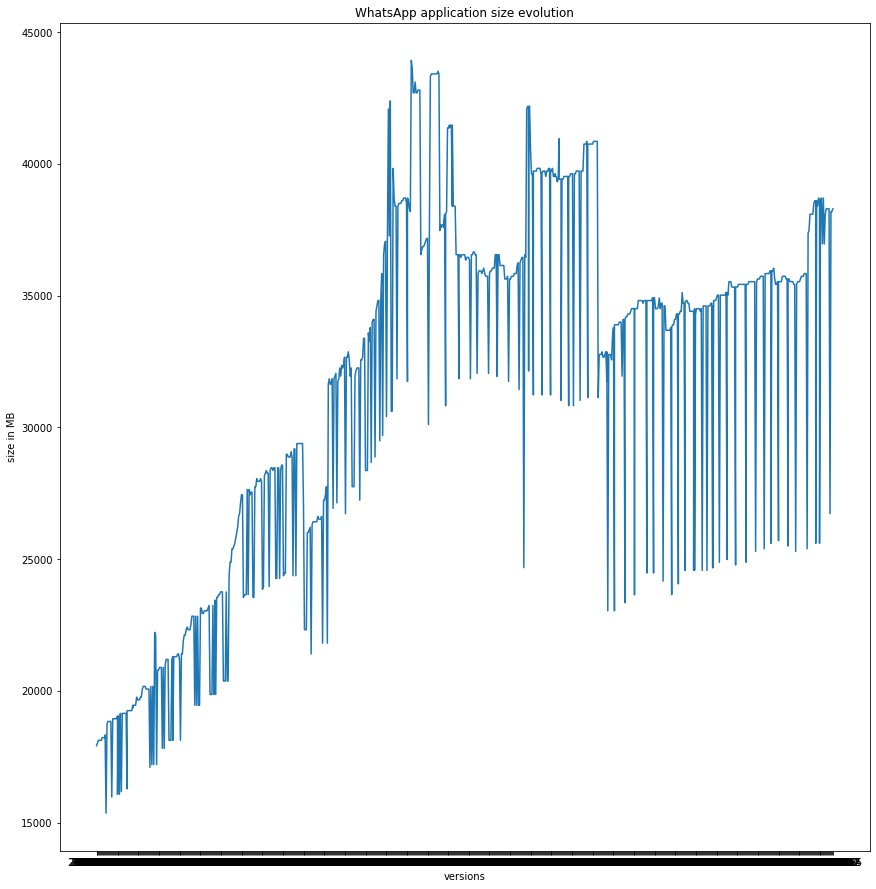

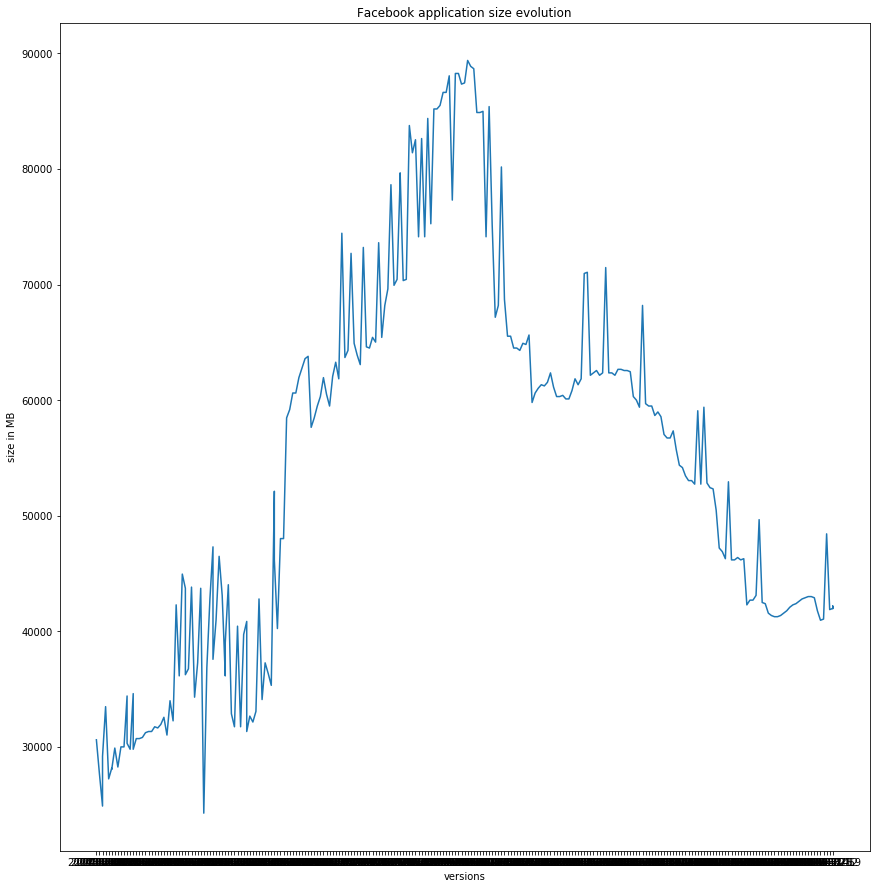

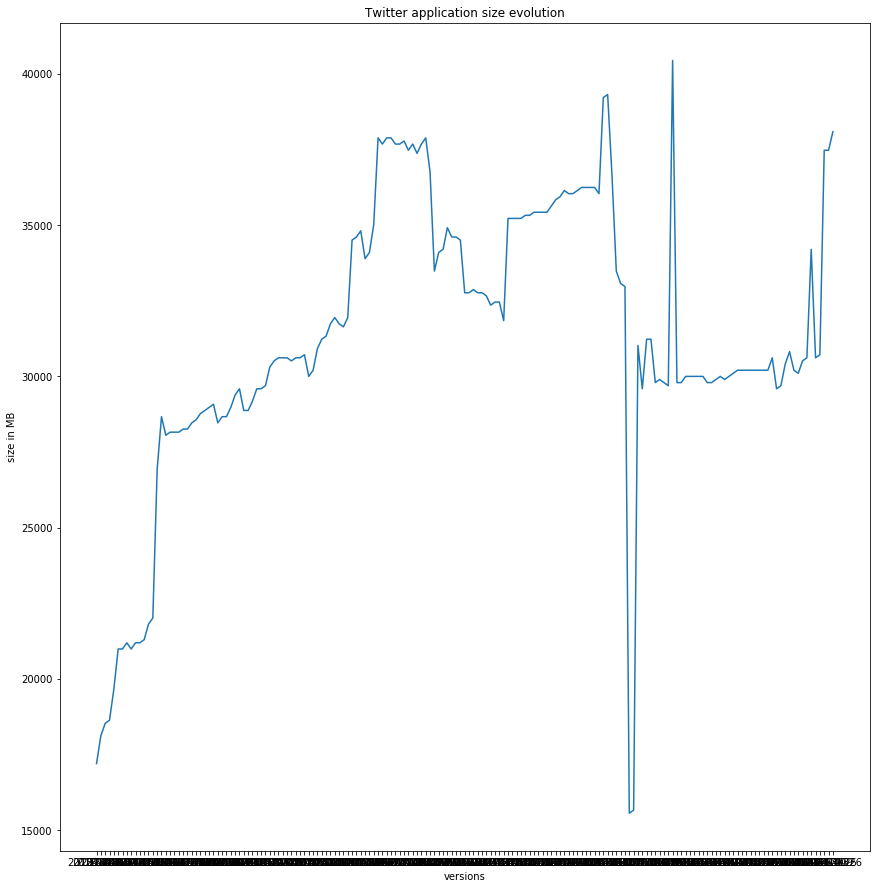

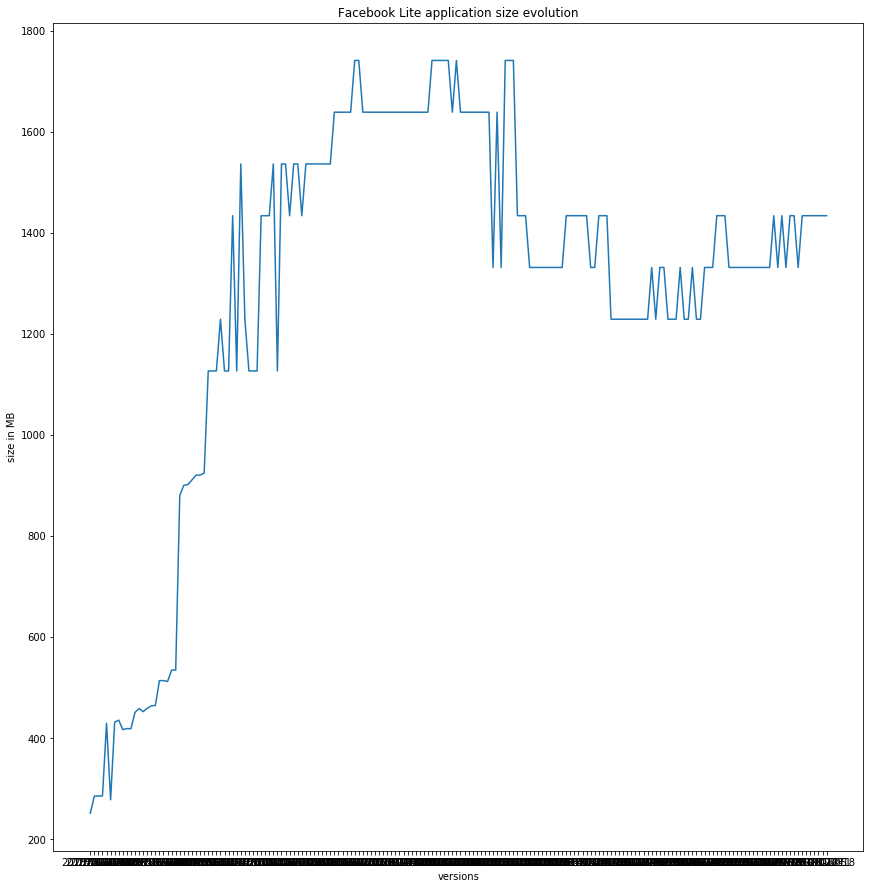

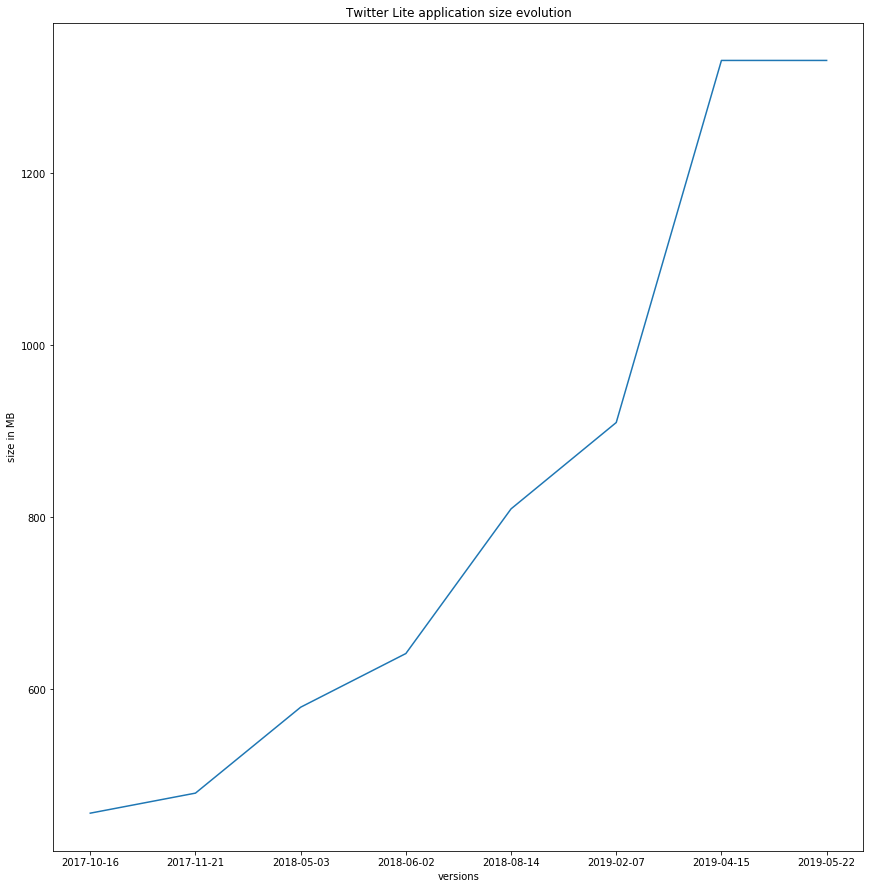

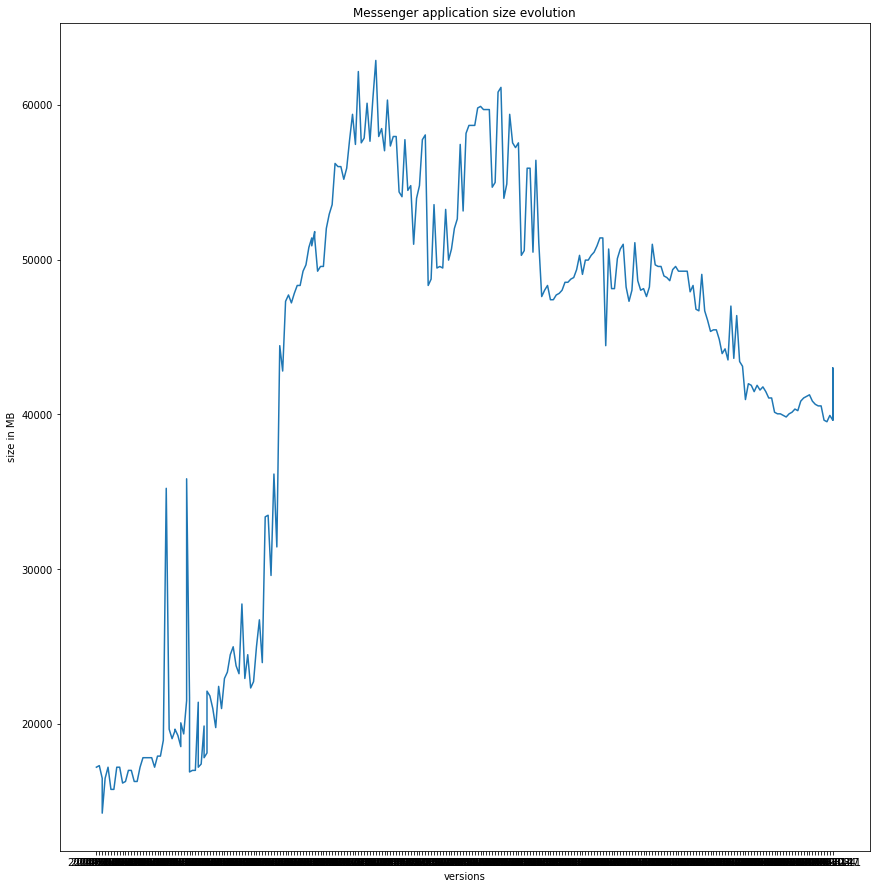

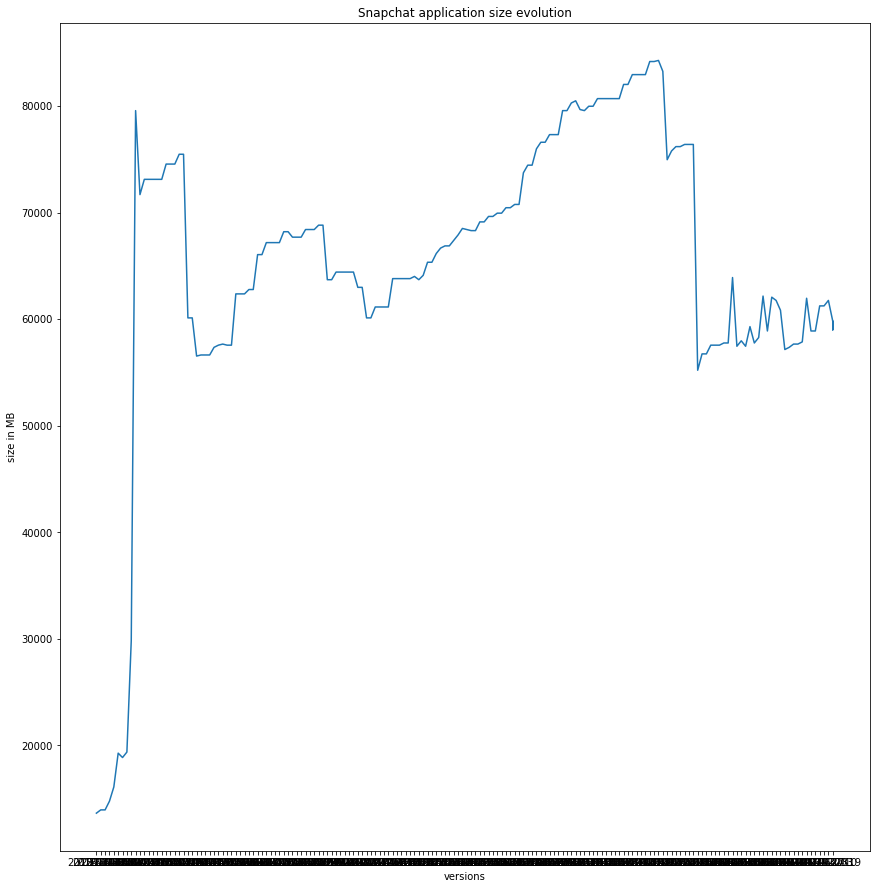

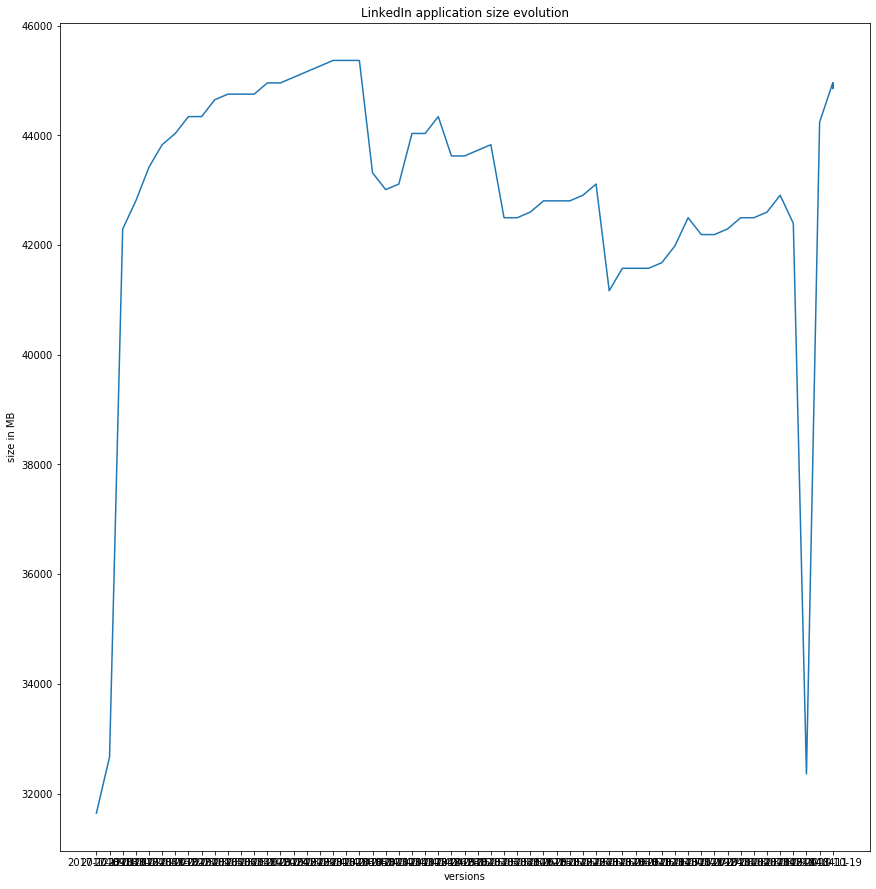

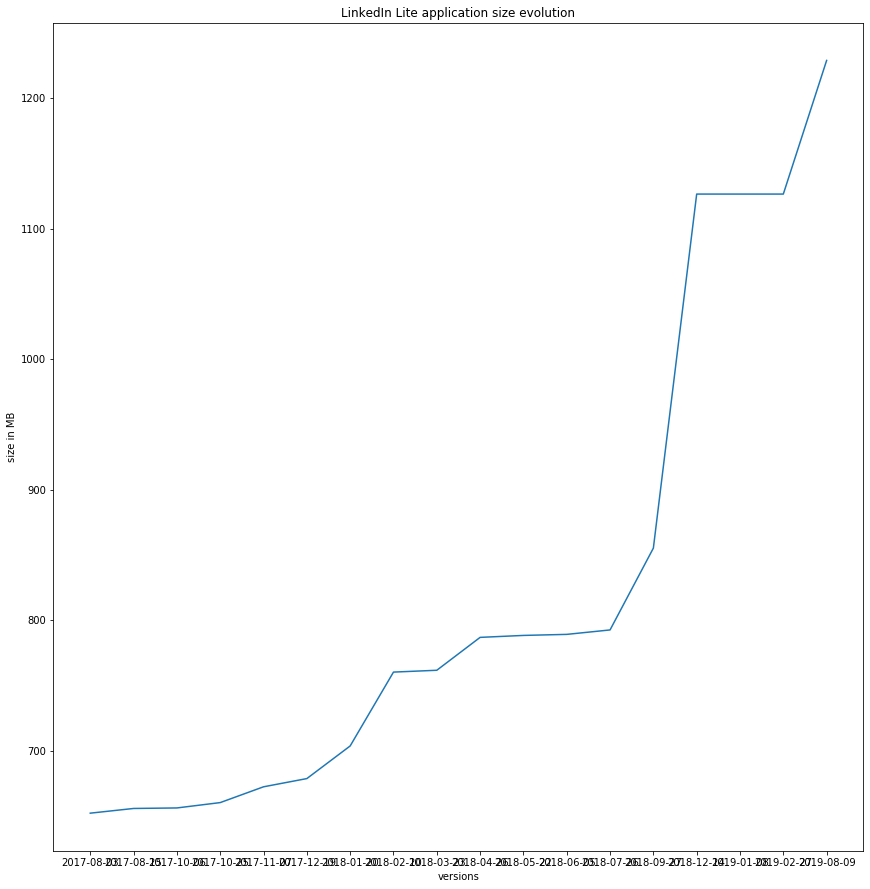

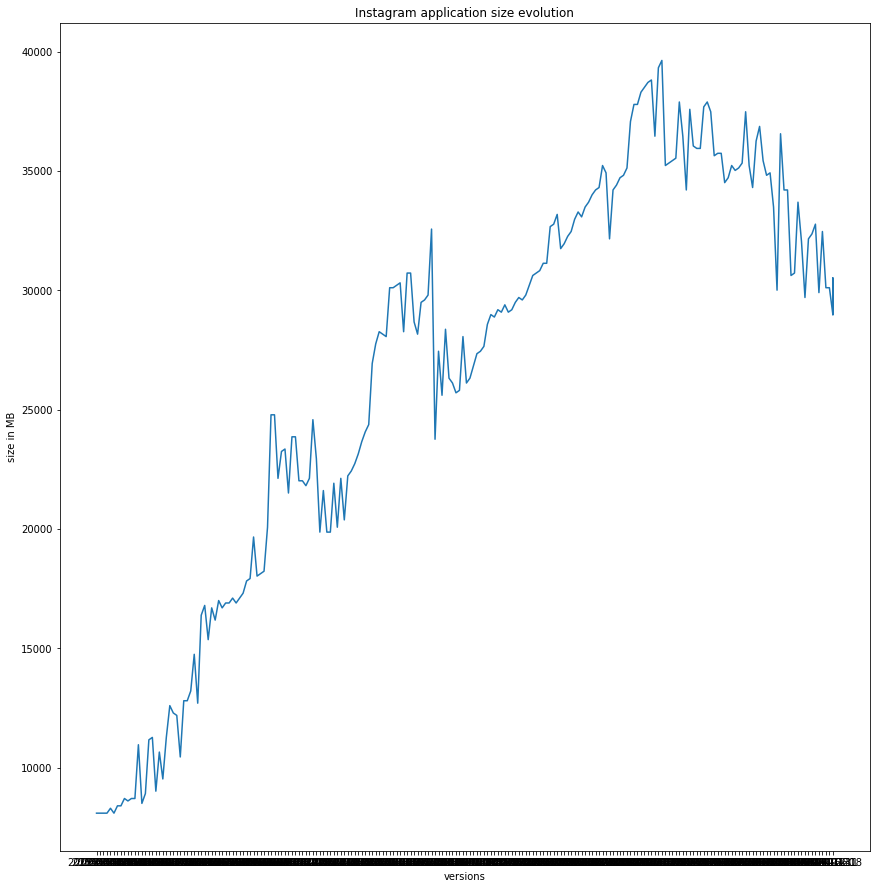

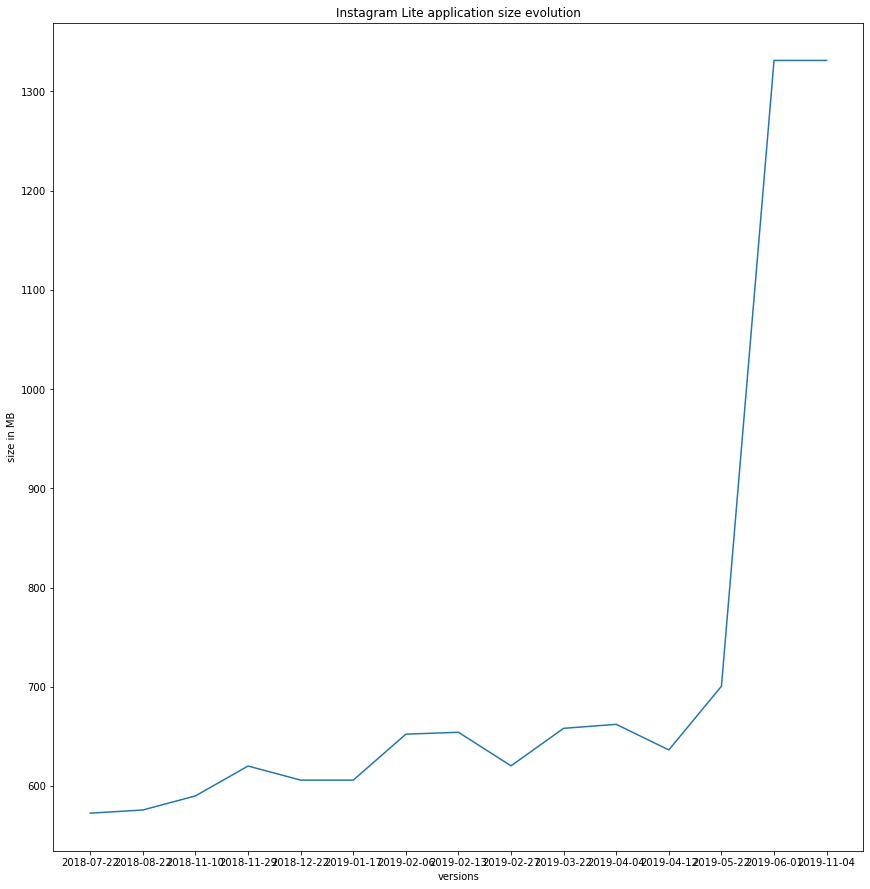

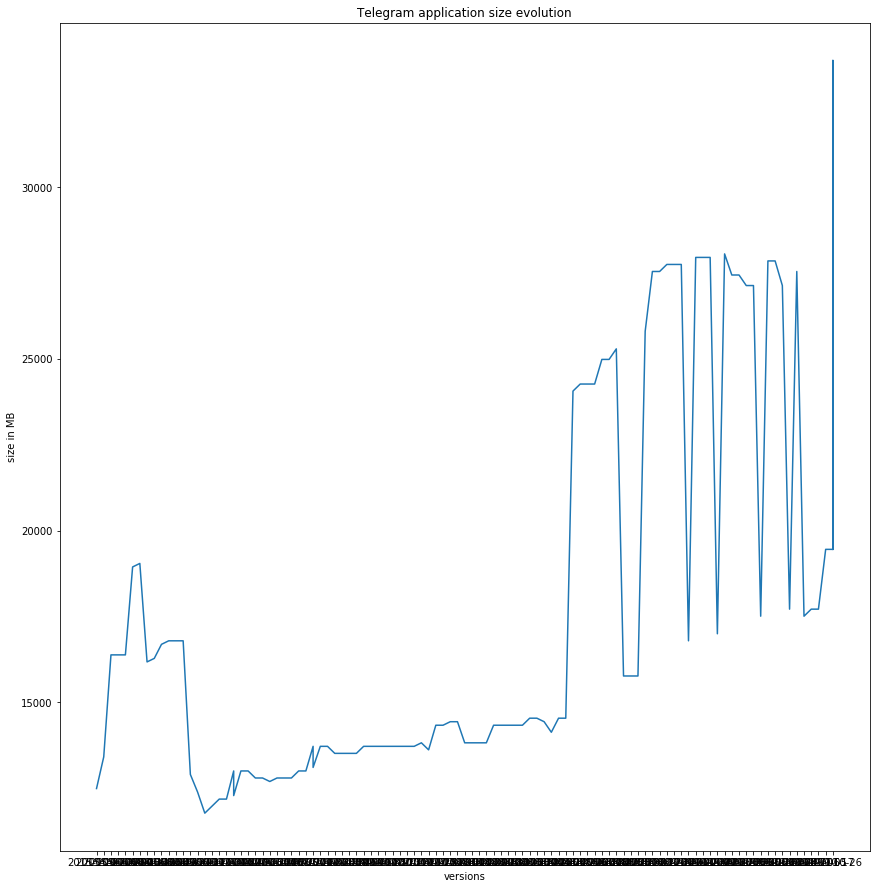

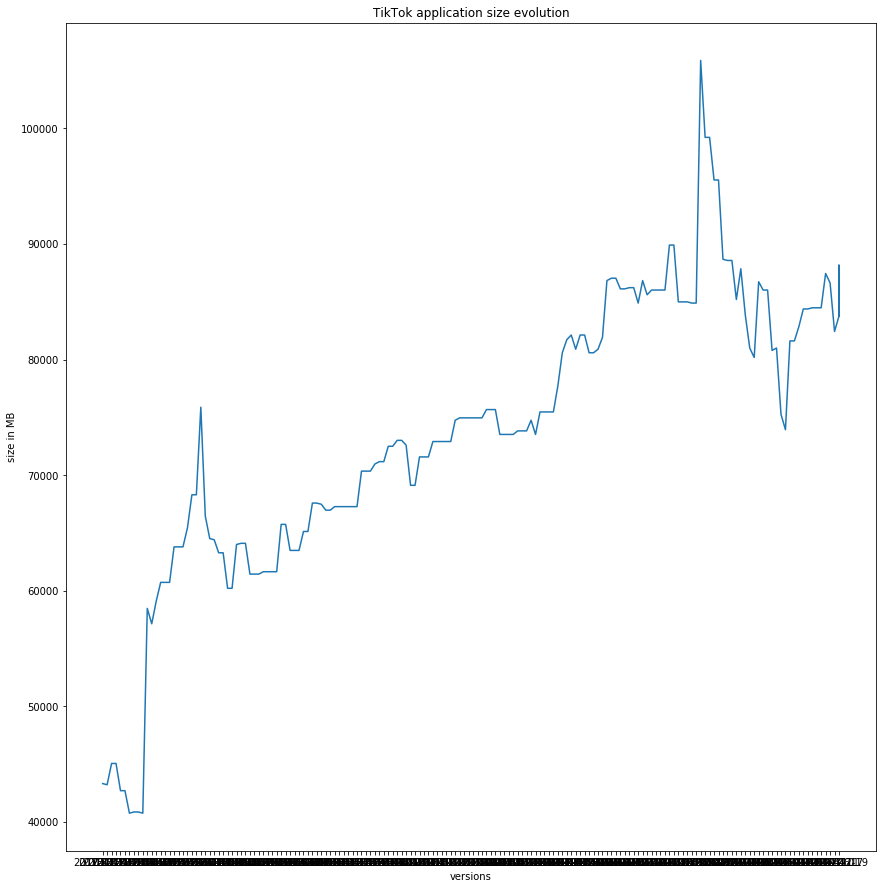

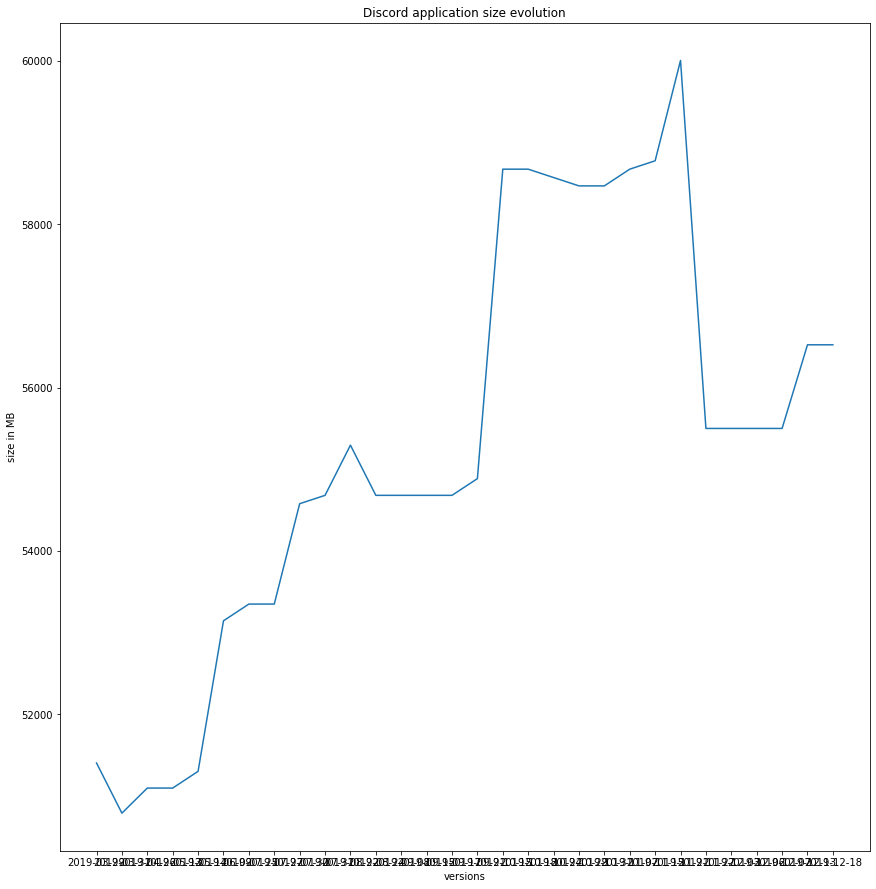

In [27]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

for name, app in applications.items():
    plt.plot([date for date, size in app[0]], [float(size.split()[0]) for date, size in app[0]])
    plt.xlabel('versions')
    plt.ylabel('size in kB')
    plt.title(name +' application size evolution')
    plt.subplots_adjust(top=3, right=2)
    plt.show()

In [28]:
def update_date(version):
    version_dict = dict()
    version_date = datetime.strptime(version[0], "%B %d, %Y")
    version_dict["date"] = version_date.strftime("%d-%m-%Y")
    l = version[1].split()
    if(l[1] == "MB"):
        l[0] = str(float(l[0]) * 1024)
        l[1] = "KB"
    version_dict["size"] = " ".join(l)
    return version_dict

def create_json(app) :
    versions = dict()
    versions["versions"] = list(app[0])
    versions["icon"] = app[1]
    return versions

In [29]:
applications_json = dict(map(lambda key_value: (key_value[0], create_json(key_value[1])), applications.items()))
file = open("data.json", "w")
file.write(json.dumps(applications_json, sort_keys=True, indent=4))
file.close()